In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("politicES_phase_2_train_public.csv", on_bad_lines='skip')

df_train.drop(['label'], axis=1, inplace=True)
#indices_aleatorios = random.sample(range(len(df_train)), 6000)
#df_train = df_train.iloc[indices_aleatorios]

In [2]:
df_train['tweet'] = df_train.apply(lambda row: row['gender'] + " " + row['profession']+ " " + row['ideology_binary']+ " " + row['tweet'], axis=1)
df_train.drop(['ideology_binary','gender','profession'], axis=1, inplace=True)

##  Clasificador

In [3]:
!pip install datasets
!pip install accelerate

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, generation, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import tensorflow as tf
from datasets import Dataset
import tqdm as notebook_tqdm

model_name = 'AIDA-UPM/BERTuit-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, from_tf=True)


/Users/juan/miniconda3/envs/master/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [5]:
import re

# Función para reemplazar emojis de puño y la bandera de España
def replace_emojis(text):
    # Patrón que incluye varios emojis de puño y la bandera de España
    puños = r"✊🏻|✊🏼|✊🏽|✊🏾|✊🏿|✊"
    españa= r"🇪🇸|🇪🇸🇪🇸|🇪🇸🇪🇸🇪🇸"
    morado= r"💜|💜💜|💜💜💜|💜💜💜"
    gay= r"🏳️‍🌈|🏳️‍🌈🏳️‍🌈|🏳️‍🌈🏳️‍🌈🏳️‍🌈"
    trans= r"🏳️‍⚧️|🏳️‍⚧️🏳️‍⚧️|🏳️‍⚧️🏳️‍⚧️🏳️‍⚧️"
    rosa= r"🌹|🌹🌹|🌹🌹🌹|🌹🌹🌹"
    brazo= r"💪|💪🏼|💪🏽|💪🏾|💪🏿|💪💪|💪🏼💪🏼|💪🏽💪🏽|💪🏾💪🏾|💪🏿💪🏿|💪💪💪|💪🏼💪🏼💪🏼|💪🏽💪🏽💪🏽|💪🏾💪🏾💪🏾|💪🏿💪🏿💪🏿"

    text = re.sub(puños, "puñoarriba", text)
    text = re.sub(españa, "banderaespaña", text)
    text = re.sub(morado, "corazonmorado", text)
    text = re.sub(gay, "lgtbi", text)
    text = re.sub(trans, "trans", text)
    text = re.sub(rosa, "rosapsoe", text)
    text = re.sub(brazo, "brazofuerte", text)

    return text


label_encoder = LabelEncoder()

df_train['ideology_multiclass'] = label_encoder.fit_transform(df_train['ideology_multiclass'])
df_train['tweet'] = df_train['tweet'].apply(replace_emojis)
df_train['tweet'] = df_train['tweet'].apply(lambda x: x.replace("@user", "<usr>"))

In [6]:

df_train, df_eval= train_test_split(df_train, test_size=0.2, stratify= df_train['ideology_multiclass'], random_state=42)

In [7]:
def tokenize_function(example):
    return tokenizer(example['tweet'])

dataset_train = Dataset.from_pandas(df_train)
dataset_eval = Dataset.from_pandas(df_eval)

In [8]:
# Aplicamos la tokenización a todo el dataset
tokenized_dataset_train = dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_eval = dataset_eval.map(tokenize_function, batched=True)
tokenized_dataset_train

Map:   0%|          | 0/162000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Dataset({
    features: ['ideology_multiclass', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 162000
})

In [9]:
tokenized_dataset_train= tokenized_dataset_train.rename_column("ideology_multiclass", "labels")
ttokenized_dataset_train= tokenized_dataset_train.remove_columns(["tweet","__index_level_0__"])

tokenized_dataset_eval= tokenized_dataset_eval.rename_column("ideology_multiclass", "labels")
tokenized_dataset_eval= tokenized_dataset_eval.remove_columns(["tweet","__index_level_0__"])  # Nos quedamos solo con los valores que necesita el modelo
tokenized_dataset_train

Dataset({
    features: ['labels', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 162000
})

In [10]:
from datasets import DatasetDict


# Creamos un DatasetDict para organizar los subconjuntos
final_datasets = DatasetDict({
    'train': tokenized_dataset_train,
    'validation': tokenized_dataset_eval,

})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Introducimos el data collator para trabajar con padding dinámico


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Macro-f1
1750,0.553000,0.507407,0.699235
3500,0.479800,0.448825,0.732277
5250,0.443800,0.440151,0.715388
7000,0.425900,0.418217,0.744549
8750,0.406000,0.393975,0.772820
10500,0.384300,0.409674,0.785988


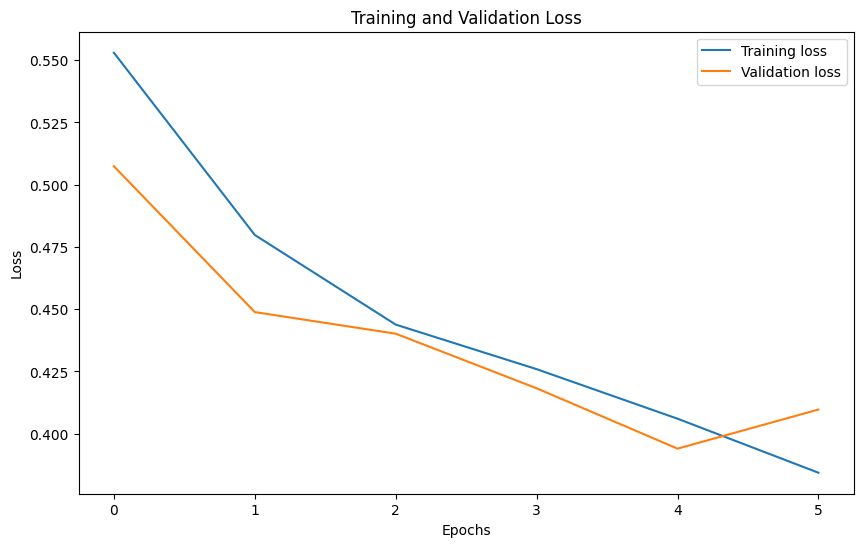

In [11]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import matplotlib.pyplot as plt

# Definimos la función encargada de evaluar las métricas en el entrenamiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    macro_f1 = f1_score(labels, predictions, average='macro') # o weighted si estan desbalceadas las clases

    return {'macro-F1': macro_f1}



# Definimos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy='steps',
    eval_steps=1750,
    save_strategy='steps',
    save_steps=1750,
    logging_strategy='steps',
    logging_dir='./logs',
    logging_steps=1750,
    load_best_model_at_end=True,
    seed=42,
)

# Inicializamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0)]
)

# Entrenamiento y evaluación
trainer.train()
training_stats = trainer.state.log_history

# Representación de las pérdidas a lo largo de las épocas
training_loss = [e['loss'] for e in training_stats if 'loss' in e]
validation_loss = [e['eval_loss'] for e in training_stats if 'eval_loss' in e]

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
from huggingface_hub import notebook_login

In [13]:
notebook_login()

In [14]:
model.save_pretrained("ideology-BERTuit-base-all-f1", push_to_hub=True)

ValueError: Token is required (write-access action) but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

In [ ]:
tokenizer.save_pretrained("ideology-BERTuit-base-all-f1", push_to_hub=True)